In [1]:
from __future__ import print_function, unicode_literals, absolute_import, division
import sys
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'


from glob import glob
from tqdm import tqdm
from tifffile import imread
from csbdeep.utils import Path, normalize
from csbdeep.utils.plot_utils import *
from csbdeep.data.transform import Transform

from stardist import fill_label_holes, random_label_cmap, calculate_extents, gputools_available
from stardist.models import Config2D, StarDist2D, StarDistData2D
from stardist.models.sample_patches import sample_patches

import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

np.random.seed(42)
lbl_cmap = random_label_cmap()

%reload_ext autoreload
%autoreload 2

print(tf.__version__)

Using TensorFlow backend.


1.13.2


In [2]:
# import tensorflow as tf
# print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

In [3]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 18442640269159943555
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 13466254899294813746
physical_device_desc: "device: XLA_CPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 7719020135
locality {
  bus_id: 1
  links {
  }
}
incarnation: 1483374374302346268
physical_device_desc: "device: 0, name: Quadro RTX 4000, pci bus id: 0000:01:00.0, compute capability: 7.5"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 7077380247078856295
physical_device_desc: "device: XLA_GPU device"
]


## Load sample data

In [4]:
%pwd

'/home/lis-paul/stardist/examples/2D'

In [5]:
X = sorted(glob('/home/lis-paul/data/dsb2018/dsb2018_sub1/images/*.tif'))
Y = sorted(glob('/home/lis-paul/data/dsb2018/dsb2018_sub1/masks/*.tif'))
assert all(Path(x).name==Path(y).name for x,y in zip(X,Y))

X = list(map(imread,X))
Y = list(map(imread,Y))
n_channel = 1 if X[0].ndim == 2 else X[0].shape[-1]

axis_norm = (0,1)   # normalize channels independently
# axis_norm = (0,1,2) # normalize channels jointly
if n_channel > 1:
    print("Normalizing image channels %s." % ('jointly' if axis_norm is None or 2 in axis_norm else 'independently'))
    sys.stdout.flush()

X = [normalize(x,1,99.8,axis=axis_norm) for x in tqdm(X)]
Y = [fill_label_holes(y) for y in tqdm(Y)]

100%|██████████| 292/292 [00:01<00:00, 241.98it/s]


In [6]:
assert len(X) > 1, "not enough training data"
rng = np.random.RandomState(42)
ind = rng.permutation(len(X))
n_val = max(1, int(round(0.15 * len(ind))))
ind_train, ind_val = ind[:-n_val], ind[-n_val:]

#manual assign train/val index for debugging
# ind_train = [1,2,3,4]
# ind_val = [0]

X_val, Y_val = [X[i] for i in ind_val]  , [Y[i] for i in ind_val]
X_trn, Y_trn = [X[i] for i in ind_train], [Y[i] for i in ind_train] 
print('number of images: %3d' % len(X))
print('- training:       %3d' % len(X_trn))
print('- validation:     %3d' % len(X_val))

number of images: 292
- training:       248
- validation:      44


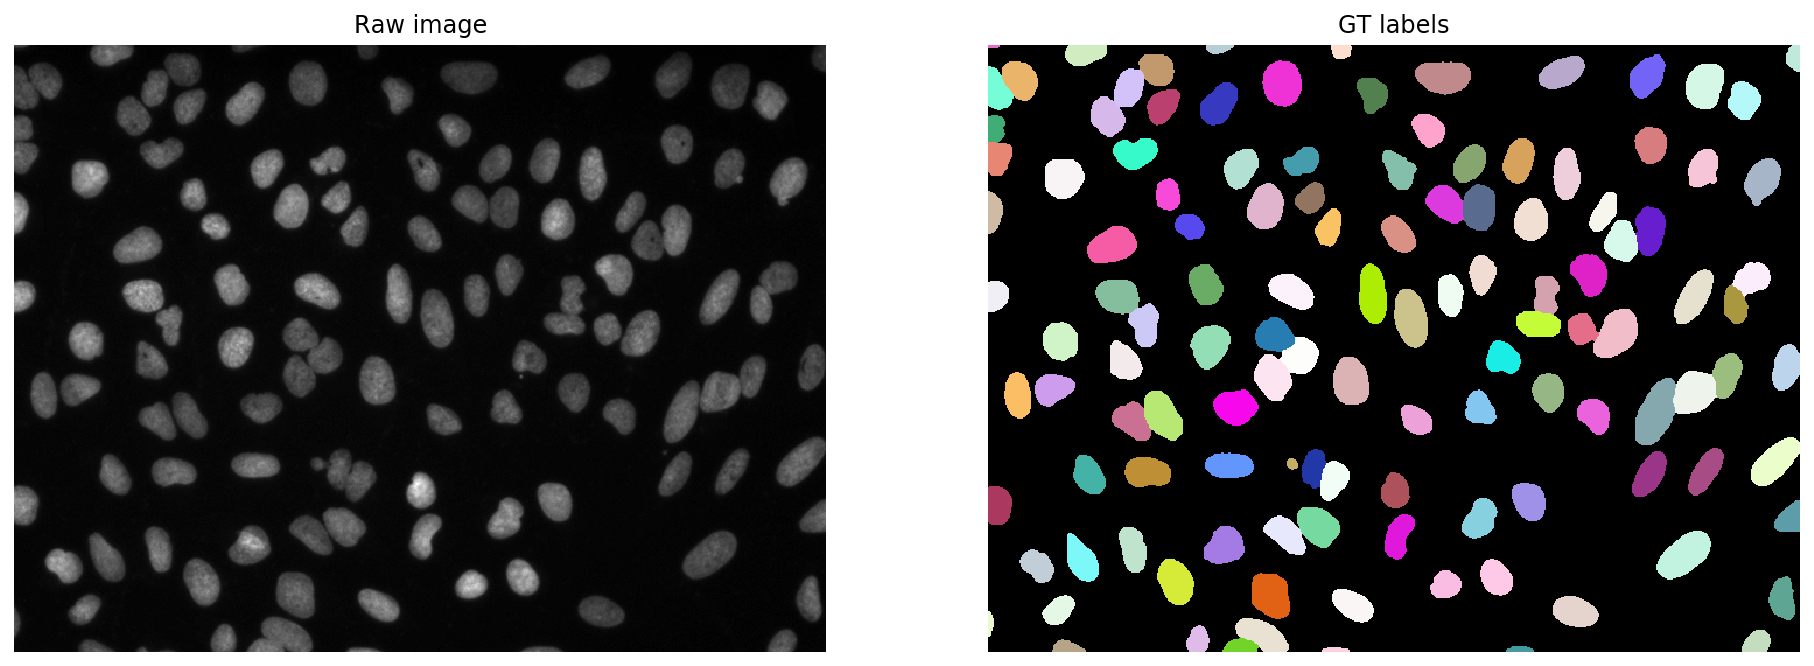

In [7]:
i = 5
# img, lbl = X[i], Y[i]
img, lbl = X_val[i], Y_val[i]
assert img.ndim in (2,3)
img = img if (img.ndim==2 or img.shape[-1]==3) else img[...,0]
plt.figure(figsize=(16,10))
plt.subplot(121); plt.imshow(img,cmap='gray');   plt.axis('off'); plt.title('Raw image')
plt.subplot(122); plt.imshow(lbl,cmap=lbl_cmap); plt.axis('off'); plt.title('GT labels')
None;

In [8]:
type(img[0][0])

numpy.float32

## Try with other augmentation packages and use stardist generator pipe (keras sequence) 

In [9]:
import cv2
from albumentations import *

In [10]:
ranf=list(np.random.ranf(8)/5)
AUGMENTATIONS_TRAIN = Compose([
    Flip(p=0.5),
    ShiftScaleRotate(shift_limit=0, scale_limit=(0.0, 1.2), rotate_limit=10, 
                     interpolation=cv2.INTER_LINEAR, border_mode=cv2.BORDER_REFLECT_101, value=0, mask_value=0, always_apply=False, p=1),
    CoarseDropout(max_holes=64, max_height=8, max_width=8, min_holes=None, min_height=None, min_width=None, 
                  fill_value=ranf, always_apply=False, p=1),
    GaussNoise(var_limit=(0.0, 0.15), mean=0, always_apply=False, p=0.5),
    GaussianBlur(blur_limit=33, p=0.5),
    ElasticTransform(alpha=100, sigma=7, alpha_affine=1, p=0.7, 
                     interpolation=cv2.INTER_LINEAR, border_mode=cv2.BORDER_REFLECT_101, value=0, mask_value=0),
], p=0.95)

In [24]:
data_train = StarDistData2D(X_trn, Y_trn, batch_size=8, n_rays=32, patch_size=(256,256), augmenter=AUGMENTATIONS_TRAIN, shape_completion=False)

In [25]:
i = np.random.randint(0,len(data_train))
XX, YY = data_train[i]

X,dist_mask = XX
prob,dist = YY

plot_some(X, dist_mask, prob, dist, x_inch=30, y_inch=20)

TypeError: clahe supports only uint8 inputs

## Train with augmentations

In [11]:
# 32 is a good default choice (see 1_data.ipynb)
n_rays = 32

# Use OpenCL-based computations for data generator during training (requires 'gputools')
use_gpu = False and gputools_available()

# Predict on subsampled grid for increased efficiency and larger field of view
grid = (2,2)

conf = Config2D (
    n_rays       = n_rays,
    grid         = grid,
    use_gpu      = False,
    n_channel_in = n_channel,
    train_batch_size = 8, 
    train_epochs = 400,
    train_steps_per_epoch = 200,
    train_one_cycle_lr_max = None,
    y_range = None,
    train_reduce_lr={'factor': 0.5, 'patience': 40, 'min_delta': 1e-5},
    train_loss_weights=(1, 0.2),
    norm_by_mask = False,
    unet_dropout = 0.6,
#     train_background_reg=0.0005,  #instead of 0.0001
#     train_learning_rate=0.008
#     net_input_shape = (X_trn[0].shape[0], X_trn[0].shape[1], n_channel)
)

conf

Config2D(axes='YXC', backbone='unet', grid=(2, 2), n_channel_in=1, n_channel_out=33, n_dim=2, n_rays=32, net_conv_after_unet=128, net_input_shape=(None, None, 1), net_mask_shape=(None, None, 1), norm_by_mask=False, train_background_reg=0.0001, train_batch_size=8, train_checkpoint='weights_best.h5', train_checkpoint_epoch='weights_now.h5', train_checkpoint_last='weights_last.h5', train_completion_crop=32, train_dist_loss='mae', train_epochs=400, train_foreground_only=0.9, train_learning_rate=0.0003, train_loss_weights=(1, 0.2), train_n_val_patches=None, train_one_cycle_lr_max=None, train_patch_size=(256, 256), train_reduce_lr={'factor': 0.5, 'patience': 40, 'min_delta': 1e-05}, train_shape_completion=False, train_steps_per_epoch=200, train_tensorboard=True, unet_activation='relu', unet_batch_norm=False, unet_dropout=0.6, unet_kernel_size=(3, 3), unet_last_activation='relu', unet_n_conv_per_depth=2, unet_n_depth=3, unet_n_filter_base=32, unet_pool=(2, 2), unet_prefix='', use_gpu=False, y

In [12]:
model = StarDist2D(conf, name='stardist', basedir='AUGA8_b8_lossw0.2_drop0.6_csbsub1')

Using default values: prob_thresh=0.5, nms_thresh=0.4.


In [13]:
model.train(X_trn, Y_trn, validation_data=(X_val,Y_val), augmenter=AUGMENTATIONS_TRAIN, multi=True, ncpu=8)


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Epoch 1/400
200/200 [==============================] - 23s 114ms/step - loss: 0.4498 - prob_loss: 0.1849 - dist_loss: 1.3247 - prob_kld: 0.1112 - dist_relevant_mae: 23.5360 - dist_relevant_mse: 920.7468 - val_loss: 0.3567 - val_prob_loss: 0.1386 - val_dist_loss: 1.0905 - val_prob_kld: 0.0550 - val_dist_relevant_mae: 16.9613 - val_dist_relevant_mse: 443.5446
Epoch 2/400
200/200 [==============================] - 18s 91ms/step - loss: 0.2900 - prob_loss: 0.1088 - dist_loss: 0.9059 - prob_kld: 0.0346 - dist_relevant_mae: 16.1378 - dist_relevant_mse: 514.6198 - val_loss: 0.2463 - val_prob_loss: 0.1153 - val_dist_loss: 0.6547 - val_prob_kld: 0.0318 - val_dist_relevant_mae: 10.1504 - val_dist_relevant_mse: 208.8123
Epoch 3/400
200/200 [========================

Probably due to custom activation function (lambda function), not be able to save model

In [23]:
# model.keras_model.save('1b_100s_400e.h5') 

# model.keras_model.load_weights('1b_100s_400e.h5')

# model.keras_model.summary()

## Threshold optimization

While the default values for the probability and non-maximum suppression thresholds already yield good results in many cases, we still recommend to adapt the thresholds to your data. The optimized threshold values are saved to disk and will be automatically loaded with the model.

In [14]:
model.optimize_thresholds(X_val, Y_val)

NMS threshold = 0.5:  80%|████████  | 16/20 [00:11<00:02,  1.40it/s, 0.432 -> 0.777]


Using optimized values: prob_thresh=0.430785, nms_thresh=0.3.
Saving to 'thresholds.json'.


{'prob': 0.43078523874282837, 'nms': 0.3}

In [103]:
%pwd

'/home/lis-paul/stardist/examples/2D'

In [51]:
model.export_TF(fname='2020-03-29-23-16_NSBE_masknorm')

## Prediction on Test set

In [15]:
X = sorted(glob('/home/lis-paul/data/centuri/test/images/*.tif'))
print(X)
X = list(map(imread,X))
len(X)

['/home/lis-paul/data/centuri/test/images/256_V1a-DMSO-x40-E1-2.tif', '/home/lis-paul/data/centuri/test/images/256_V1a-DMSO-x40-E2-1.tif', '/home/lis-paul/data/centuri/test/images/256_V1a-WT-x40-E1-1.tif', '/home/lis-paul/data/centuri/test/images/256_V1a-WT-x40-E3-2.tif', '/home/lis-paul/data/centuri/test/images/256_V1a-WT-x40-E3-5.tif', '/home/lis-paul/data/centuri/test/images/V1a-DMSO-x40-E1-2.tif', '/home/lis-paul/data/centuri/test/images/V1a-DMSO-x40-E2-1.tif', '/home/lis-paul/data/centuri/test/images/V1a-WT-x40-E1-1.tif', '/home/lis-paul/data/centuri/test/images/V1a-WT-x40-E3-2.tif', '/home/lis-paul/data/centuri/test/images/V1a-WT-x40-E3-5.tif']


10

In [16]:
n_channel = 1 if X[0].ndim == 2 else X[0].shape[-1]
axis_norm = (0,1)   # normalize channels independently
# axis_norm = (0,1,2) # normalize channels jointly
if n_channel > 1:
    print("Normalizing image channels %s." % ('jointly' if axis_norm is None or 2 in axis_norm else 'independently'))

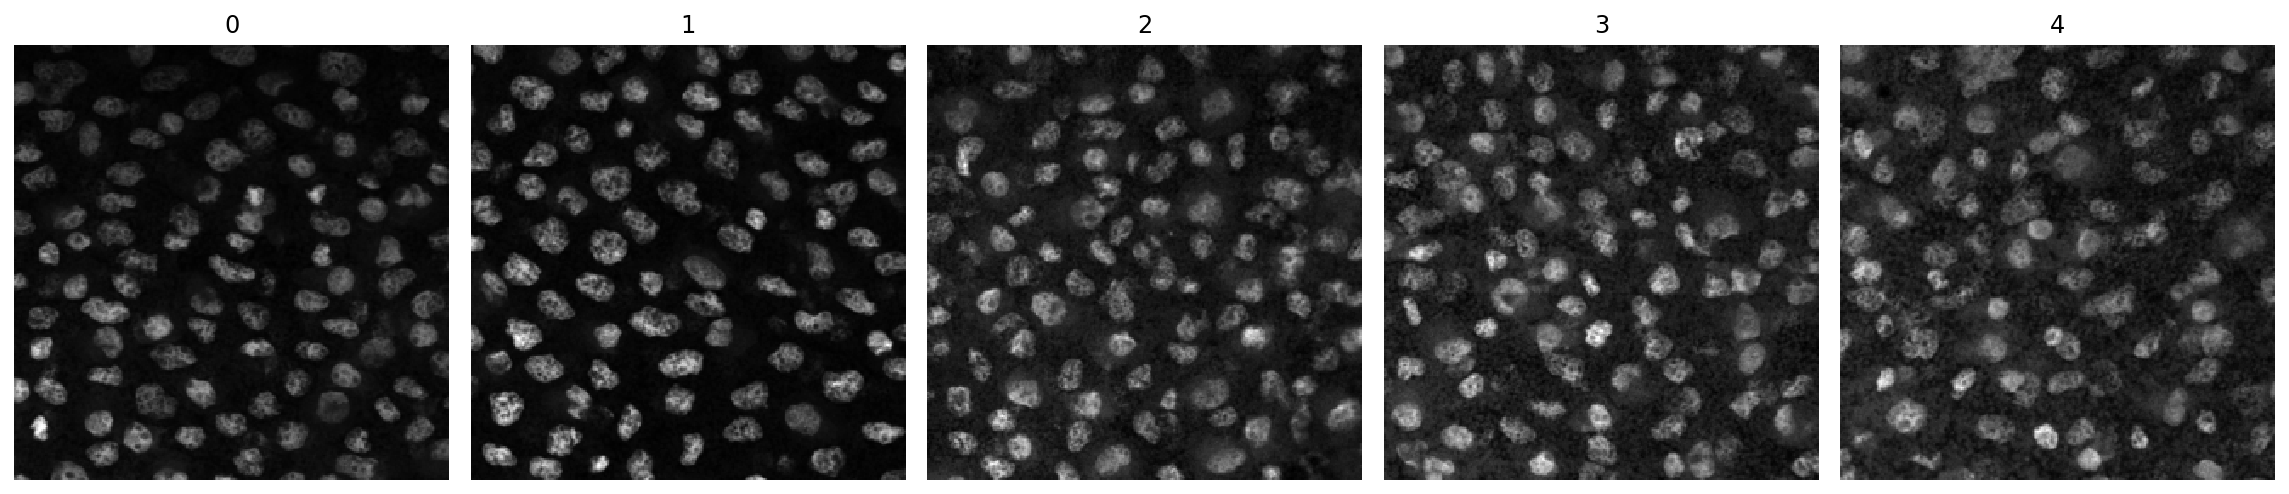

In [17]:
# show all test images
if True:
    fig, ax = plt.subplots(1,5, figsize=(16,16))
    for i,(a,x) in enumerate(zip(ax.flat, X)):
        a.imshow(x if x.ndim==2 else x[...,0], cmap='gray')
        a.set_title(i)
    [a.axis('off') for a in ax.flat]
    plt.tight_layout()
None;

# Load trained model

If you trained your own StarDist model (and optimized its thresholds) via notebook [2_training.ipynb](2_training.ipynb), then please set `demo_model = False` below.

In [8]:
# model = StarDist2D(None,  name='stardist', basedir='AUGA2_b8_lossw0.05_drop0.1_csbsub1')

Loading network weights from 'weights_best.h5'.
Couldn't load thresholds from 'thresholds.json', using default values. (Call 'optimize_thresholds' to change that.)
Using default values: prob_thresh=0.5, nms_thresh=0.4.


In [135]:
# demo_model = False

# if demo_model:
#     print (
#         "NOTE: This is loading a previously trained demo model!\n"
#         "      Please set the variable 'demo_model = False' to load your own trained model.",
#         file=sys.stderr, flush=True
#     )
#     model = StarDist2D(None, name='2D_demo', basedir='../../models/examples')
# else:
#     model = StarDist2D(None, name='stardist_tune', basedir='tune5_c0_csbsub')
# None;

(1022, 1022)


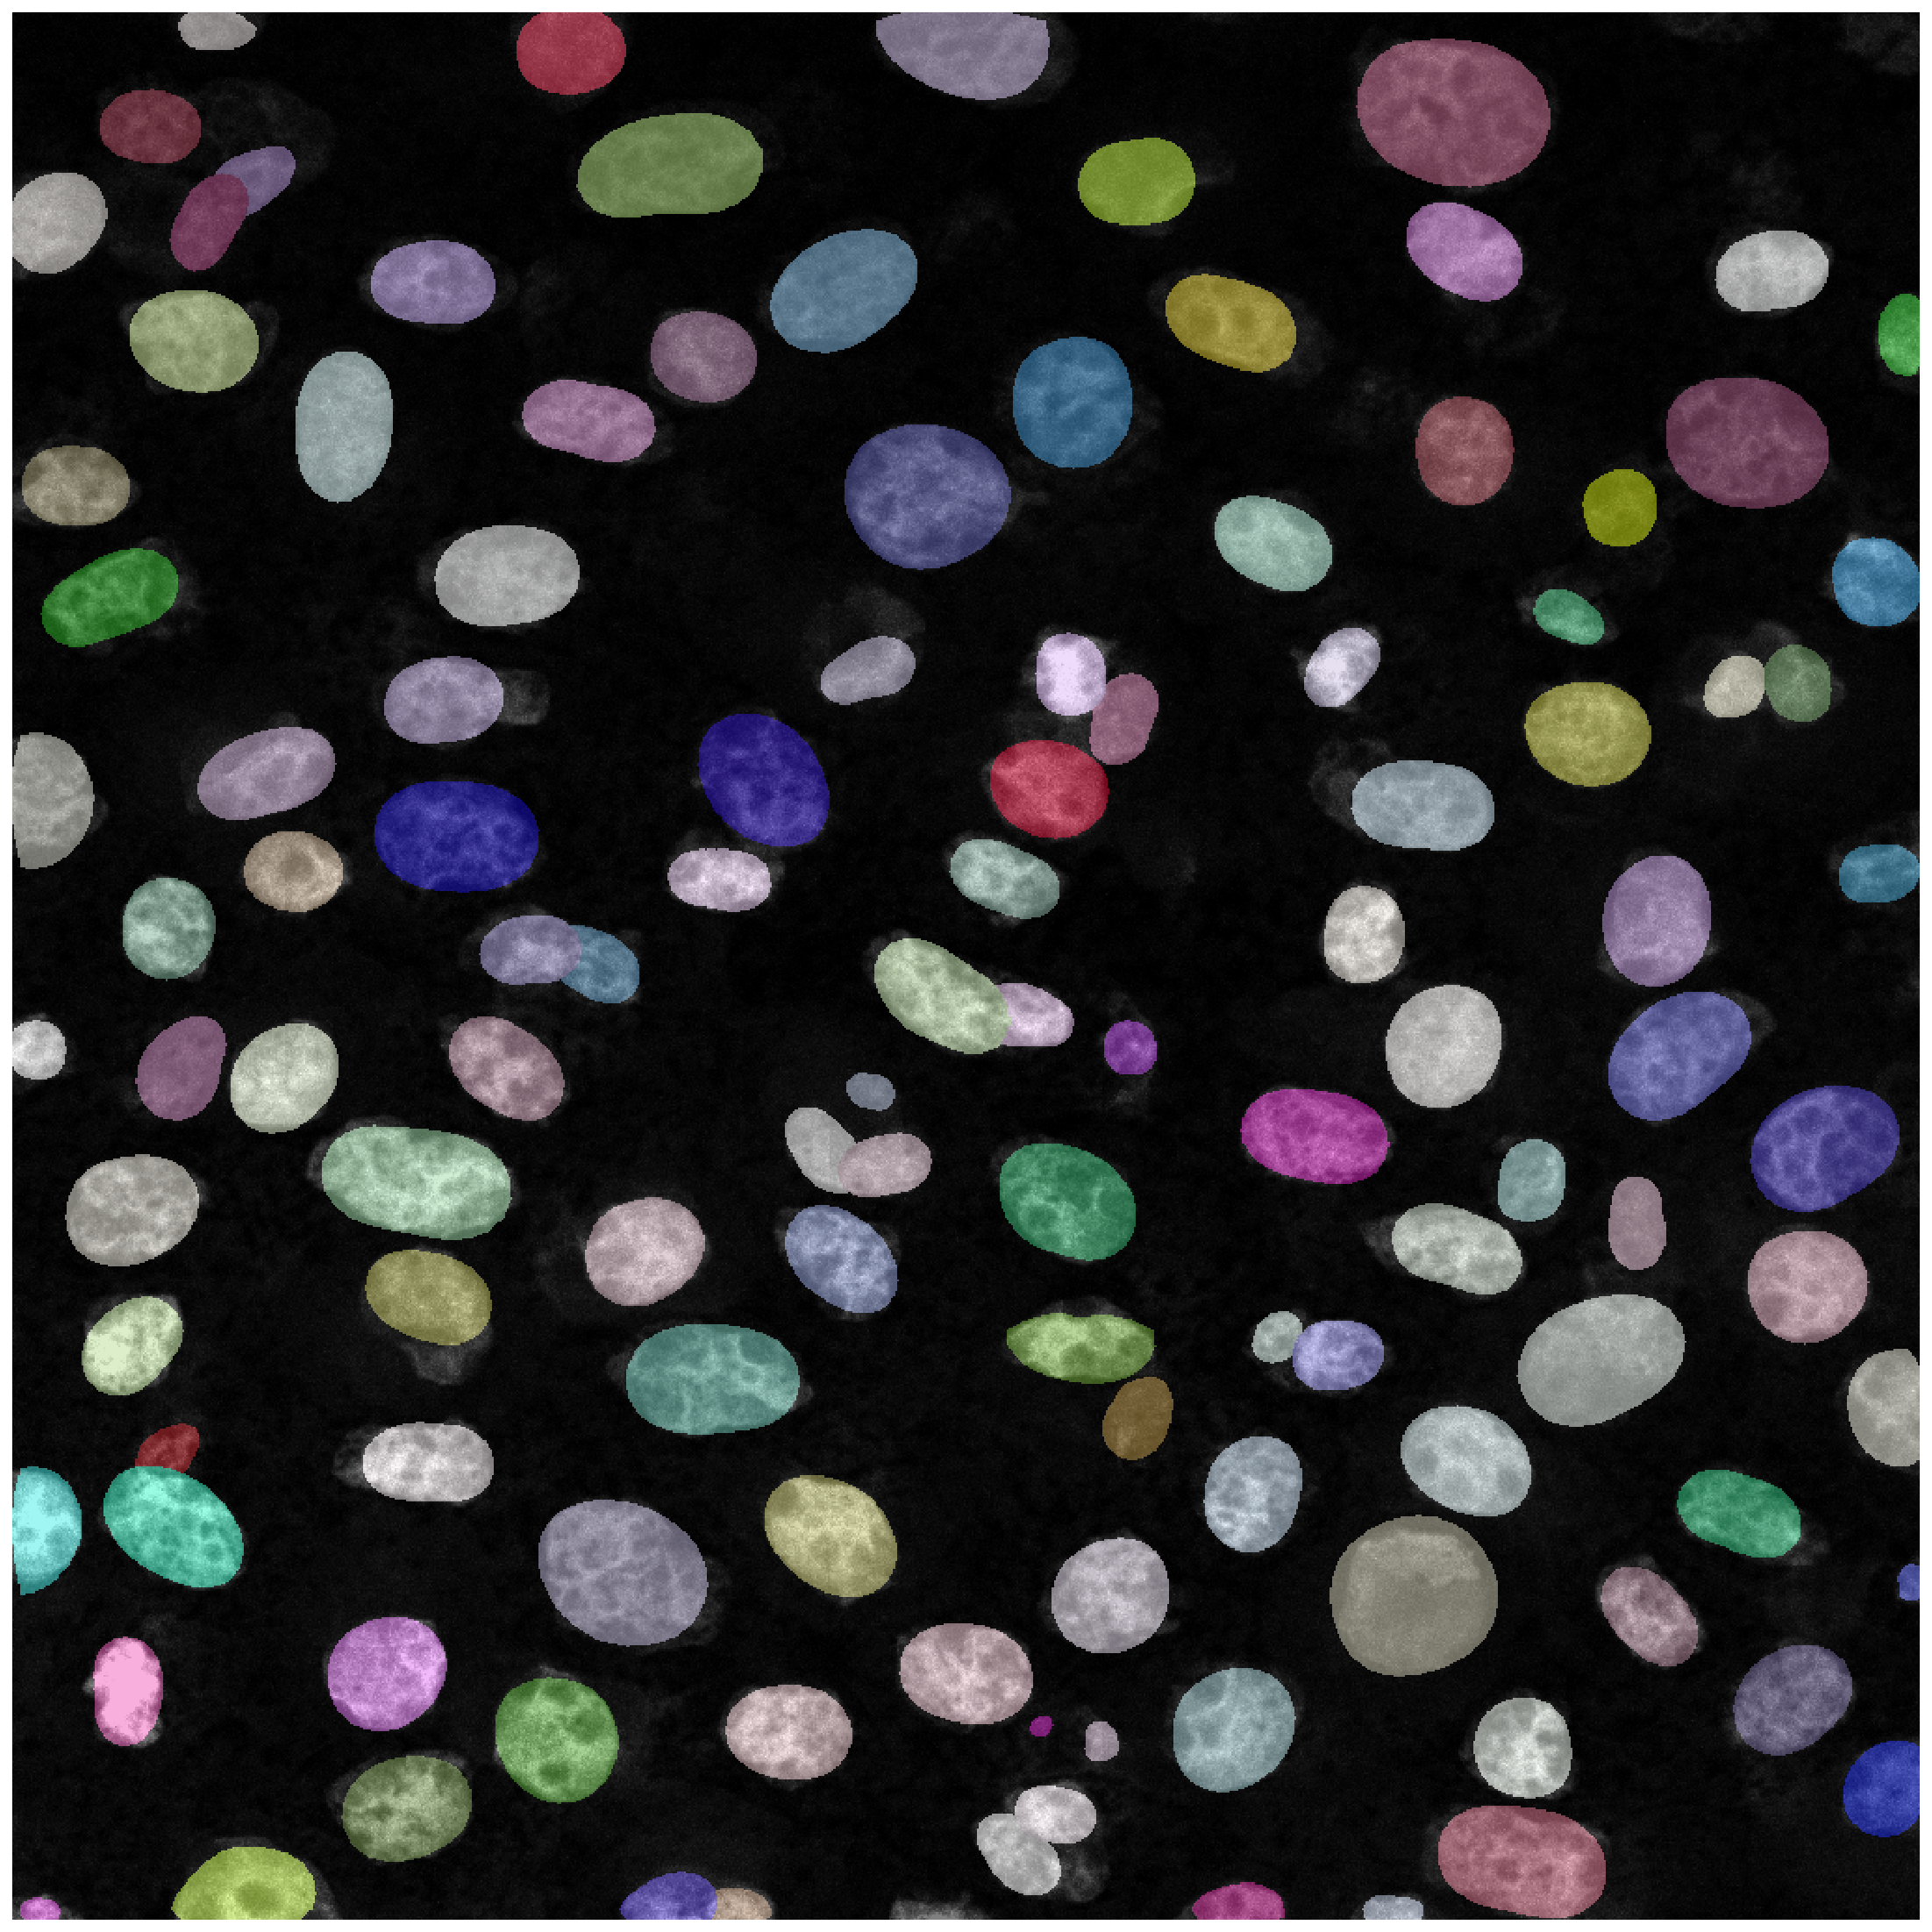

In [21]:
img = normalize(X[5], 1,99.8, axis=axis_norm)
labels, details = model.predict_instances(img, prob_thresh=0.48, nms_thresh=0.3)
print(img.shape)
plt.figure(figsize=(20,20))
plt.imshow(img if img.ndim==2 else img[...,0], clim=(0,1), cmap='gray')
plt.imshow(labels, cmap=lbl_cmap, alpha=0.5)
plt.axis('off');

(520, 696)


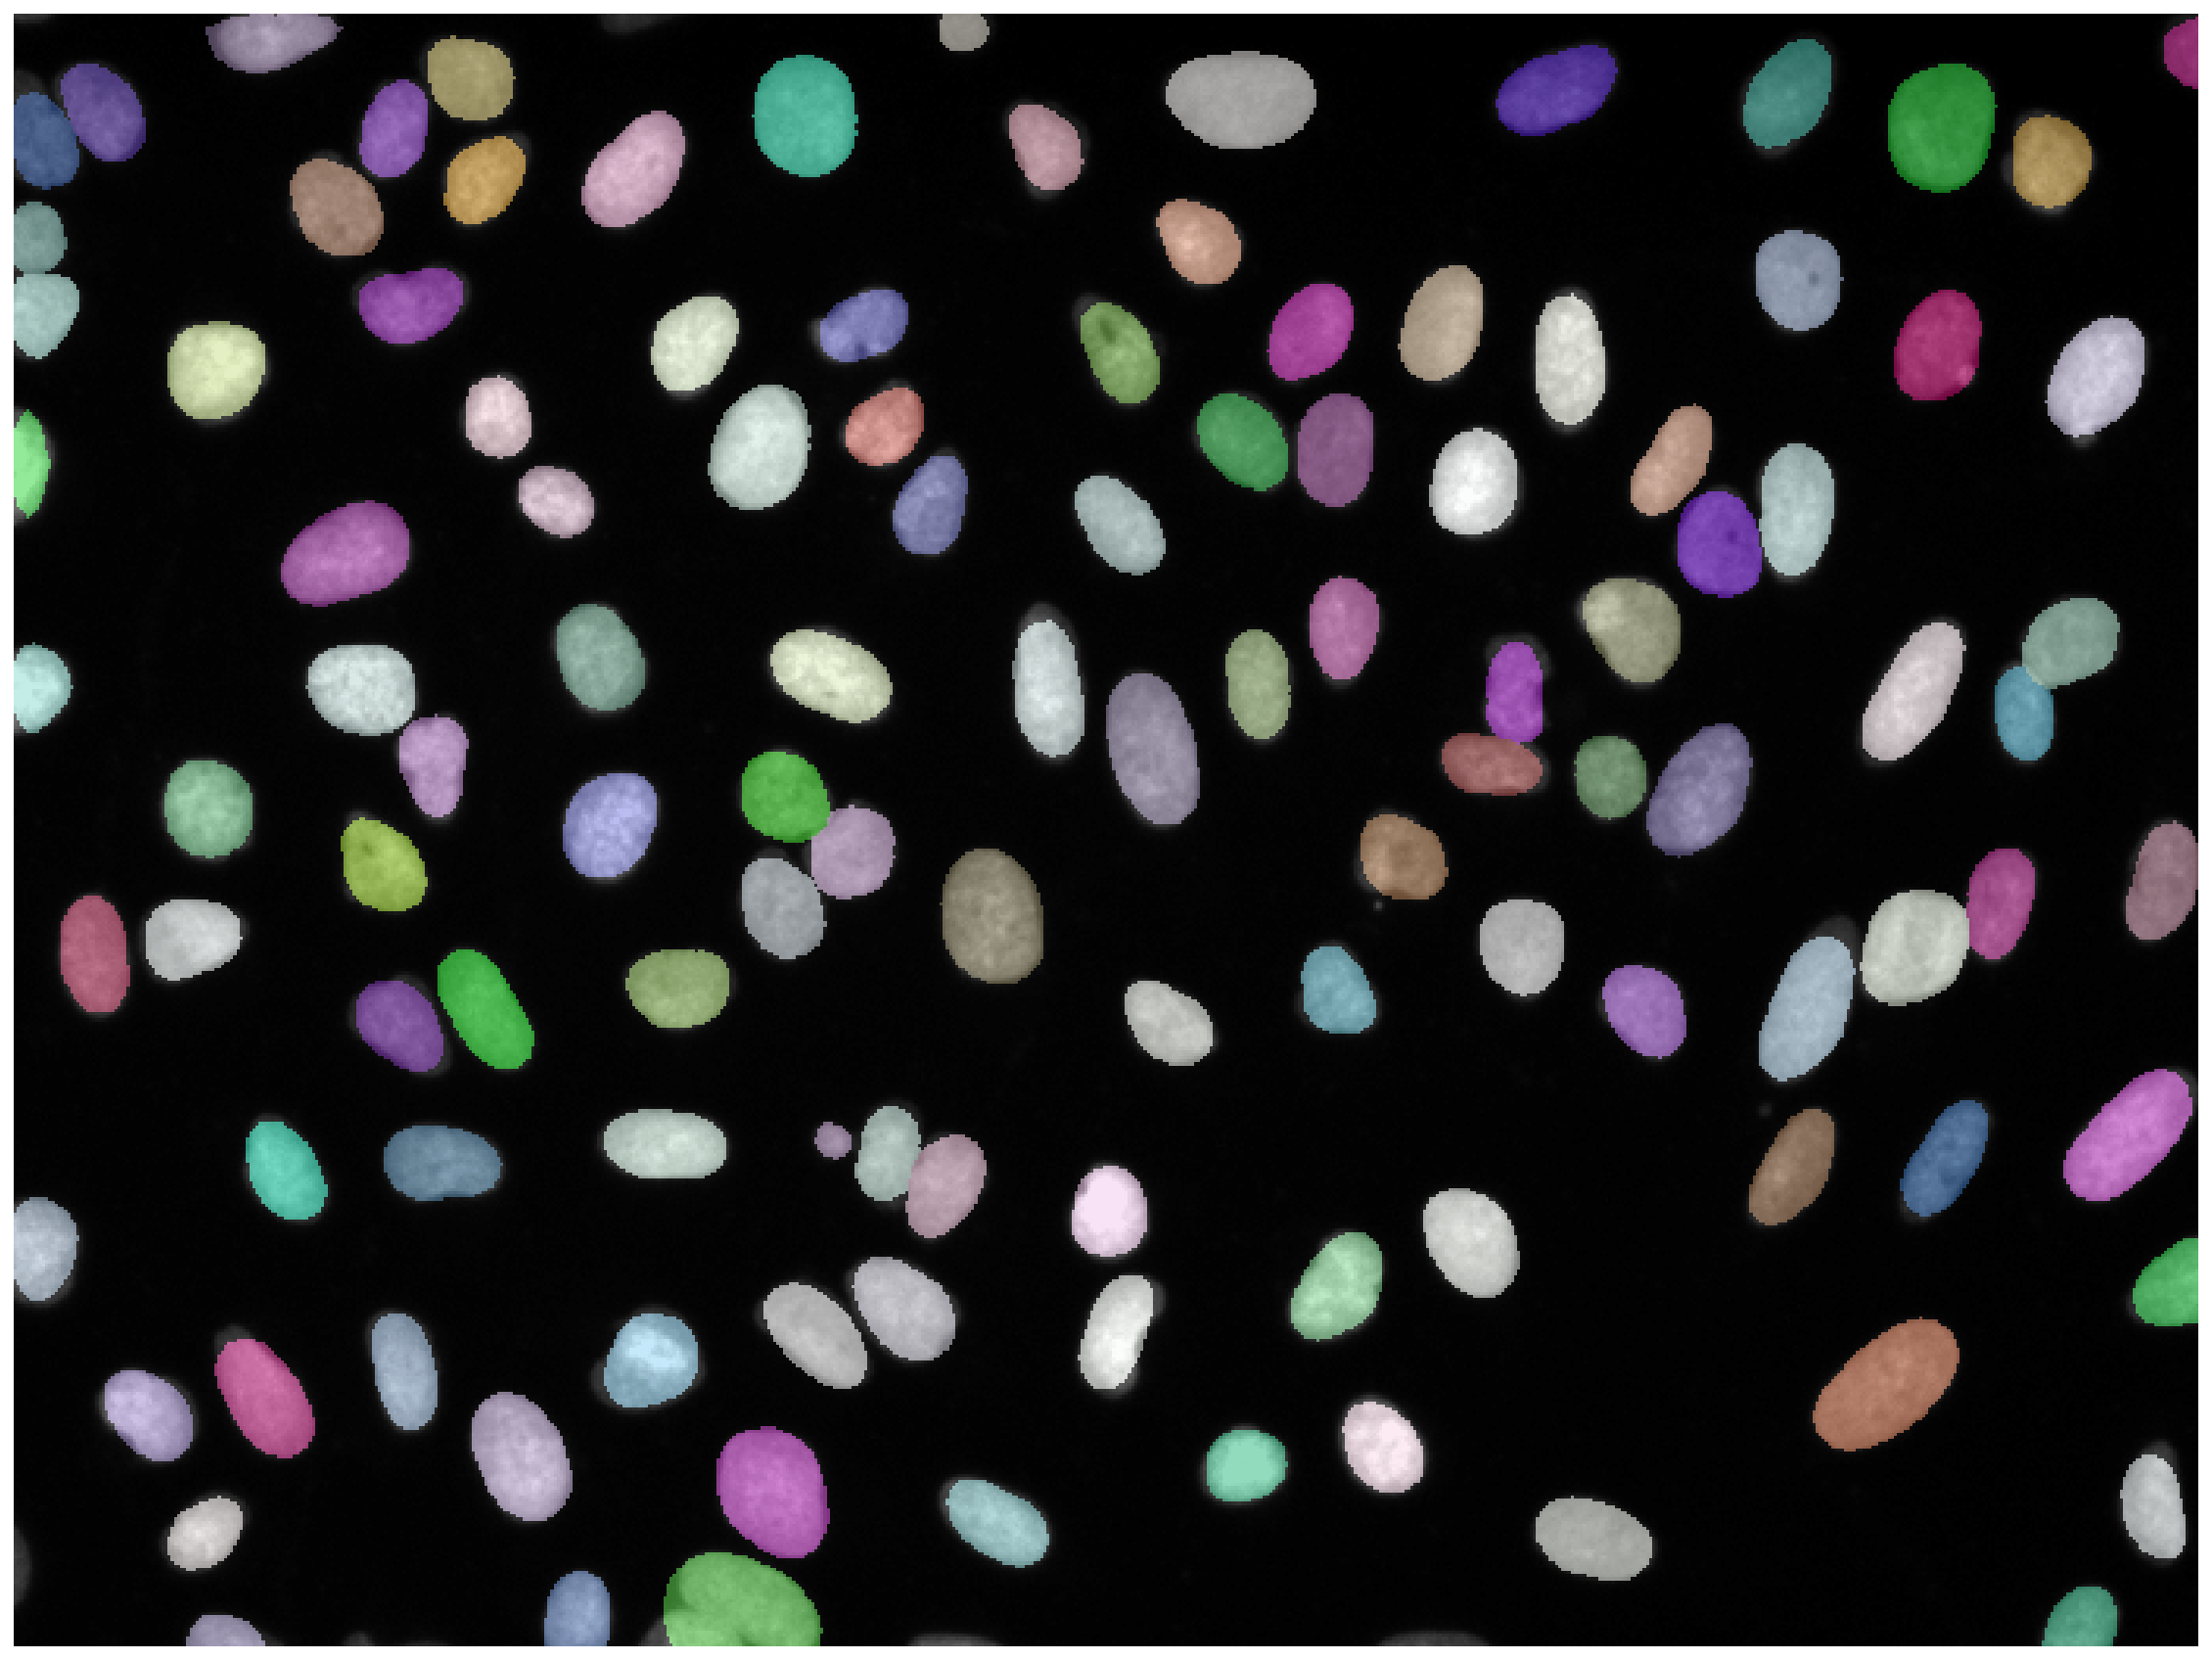

In [22]:
img = normalize(X_val[5], 1,99.8, axis=axis_norm)
labels, details = model.predict_instances(img)

print(img.shape)
plt.figure(figsize=(20,20))
plt.imshow(img if img.ndim==2 else img[...,0], clim=(0,1), cmap='gray')
plt.imshow(labels, cmap=lbl_cmap, alpha=0.5)
plt.axis('off');

#### Example results

In [25]:
from stardist import random_label_cmap, _draw_polygons

def example(model, i, show_dist=True):
    img = normalize(X_val[i], 1,99.8, axis=axis_norm)
    labels, details = model.predict_instances(img)

    plt.figure(figsize=(13,10))
    img_show = img if img.ndim==2 else img[...,0]
    coord, points, prob = details['coord'], details['points'], details['prob']
    plt.subplot(121); plt.imshow(img_show, cmap='gray'); plt.axis('off')
    a = plt.axis()
    _draw_polygons(coord, points, prob, grid=model.config.grid, show_dist=show_dist)
    plt.axis(a)
    plt.subplot(122); plt.imshow(img_show, cmap='gray'); plt.axis('off')
    plt.imshow(labels, cmap=lbl_cmap, alpha=0.5)
    plt.tight_layout()
    plt.show()

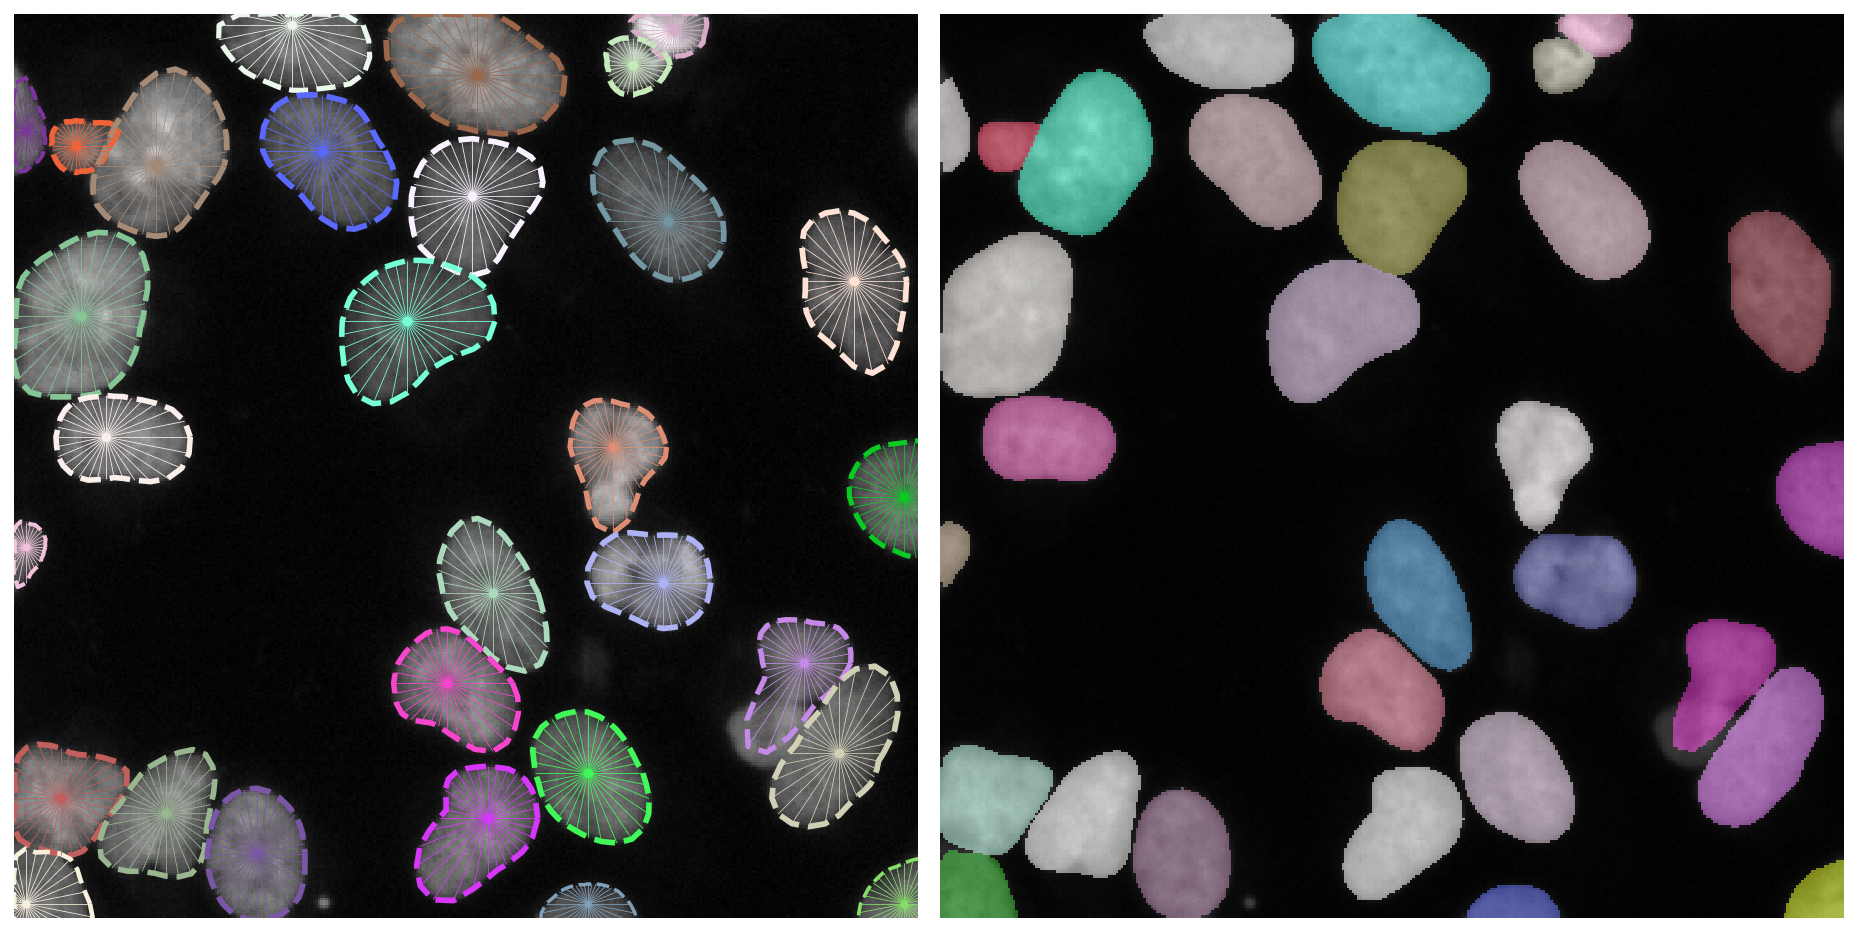

In [27]:
example(model, 1)